# Лабораторная работа №6 “Кластеризация”

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

## 1. Загрузите данные ex6data1.mat из файла.

In [105]:
from scipy.io import loadmat

mat = loadmat('data/ex6data1.mat')
x = mat['X']

## 2. Реализуйте функцию случайной инициализации K центров кластеров.

In [220]:
def init_centroids(X, K):
    m,n = X.shape[0], X.shape[1]
    centroids = np.zeros((K,n))
    
    for i in range(K):
        centroids[i] = X[np.random.randint(0 ,m+1),:]

    return centroids

## 3. Реализуйте функцию определения принадлежности к кластерам.

In [221]:
def find_closes_clusters(X, centroids):
    K = centroids.shape[0]
    clusters = np.zeros(len(X), dtype=int)
    temp = np.zeros((centroids.shape[0],1))

    for i in range(X.shape[0]):
        for j in range(K):
            dist = X[i,:] - centroids[j,:]
            length = np.sum(dist**2)
            temp[j] = length

        clusters[i] = np.argmin(temp)

    return clusters

## 4. Реализуйте функцию пересчета центров кластеров.

In [222]:
def update_centroids(X, clusters, K):
    new_centroids = np.zeros((K, X.shape[1]))
    for k in range(K):
        if len(X[clusters == k]) == 0:
            continue
        new_centroids[k] = X[clusters == k].mean(axis=0)

    return new_centroids

## 5. Реализуйте алгоритм K-средних.

In [223]:
def k_means(X, centroids, clusters, K, num_iters):
    logs = [centroids]
    for i in range(num_iters):
        centroids = update_centroids(X, clusters, K)
        logs.append(centroids)
        clusters = find_closes_clusters(X, centroids)

    return clusters, logs

## 6. Постройте график, на котором данные разделены на K=3 кластеров (при помощи различных маркеров или цветов), а также траекторию движения центров кластеров в процессе работы алгоритма.


In [224]:
def plot_k_means(X, clusters, cenroids_moving_logs):
    """
    plots the data points with colors assigned to each centroid
    """
    m, n = X.shape[0], X.shape[1]
    plt.scatter(X[:, 0], X[:, 1], c=clusters)

    clusters_centroids = [[], [], [], [], [], []]
    for centroids in cenroids_moving_logs:
        for idx, cl_centroid in enumerate(centroids):
            clusters_centroids[idx * 2].append(cl_centroid[0])
            clusters_centroids[idx * 2 + 1].append(cl_centroid[1])
    
    plt.plot(*clusters_centroids, marker='x')
    plt.show()

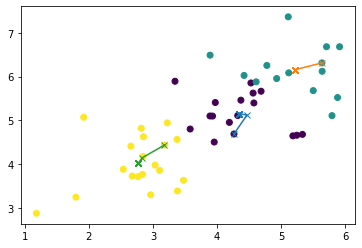

In [225]:
K = 3
initial_centroids = init_centroids(x, K)
clusters = find_closes_clusters(x, initial_centroids)
result_clusters, cenroids_moving_logs = k_means(x, initial_centroids, clusters, 3, 50)
cenroids_moving_logs
plot_k_means(x, result_clusters, cenroids_moving_logs)

## 7. Загрузите данные bird_small.mat из файла.

In [266]:
mat2 = loadmat('data/bird_small.mat')
A = mat2["A"]

# preprocess and reshape the image
X = (A / 255).reshape(128*128, 3)

## 8. С помощью алгоритма K-средних используйте 16 цветов для кодирования пикселей.

In [267]:
K = 16
num_iters = 10
initial_centroids = init_centroids(X, K)
initial_clusters = find_closes_clusters(X, initial_centroids)
clusters, centroids_changing_logs  = k_means(X, initial_centroids, initial_clusters, K, num_iters=10)
centroids = centroids_changing_logs[-1]

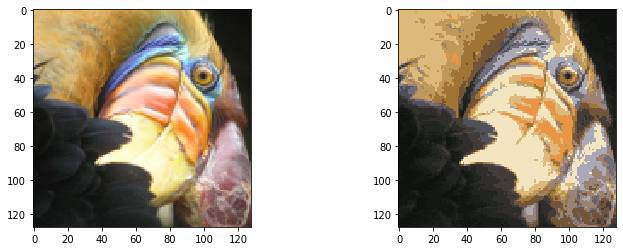

In [268]:
m, n = X.shape[0], X.shape[1]
X_recovered = X.copy()
for i in range(0, K):
    X_recovered[(clusters==i).ravel(),:] = centroids[i]

# Reshape the recovered image into proper dimensions
X_recovered = X_recovered.reshape(128, 128, 3)

# Display the image
import matplotlib.image as mpimg
fig, ax = plt.subplots(1,2, figsize=[12, 4])
ax[0].imshow(X.reshape(128,128,3))
ax[1].imshow(X_recovered)

## 9. Насколько уменьшился размер изображения? Как это сказалось на качестве?


Каждый пиксель в исходном изображении - 3 байта.
В сжатом изображении достаточно полбайта для хранения цвета пикселя.

Таким образом, мы сжимаем картинку в 6 раз.

## 10. Реализуйте алгоритм K-средних на другом изображении.

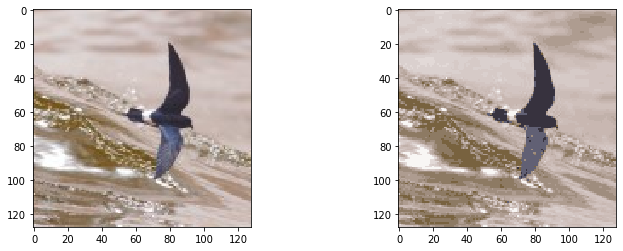

In [274]:
import cv2

A = cv2.imread('data/bird_example.jpg')
K = 16

X = np.reshape(A, [A.shape[0] * A.shape[1], A.shape[2]])
initial_centroids = init_centroids(X, K)
initial_clusters = find_closes_clusters(X, initial_centroids)
clusters, centroids_changing_logs  = k_means(X, initial_centroids, initial_clusters, K, num_iters=10)
centroids = centroids_changing_logs[-1]

new_colors = np.round(centroids).astype(np.uint8)

image = X.copy()
for i in range(X.shape[0]):
    image[i, :] = new_colors[clusters[i]]

compressed_img = image.reshape(A.shape)

fig, axs = plt.subplots(1, 2, figsize=[12, 4])
axs[0].imshow(img)
axs[1].imshow(compressed_img)

## 11. Реализуйте алгоритм иерархической кластеризации на том же изображении. Сравните полученные результаты.

In [275]:
from sklearn.cluster import AgglomerativeClustering

def compress_hierarchical_clusters(img, n_colors=16):
    X = np.reshape(img, [img.shape[0] * img.shape[1], img.shape[2]])

    cluster = AgglomerativeClustering(n_clusters=n_colors, affinity='euclidean', linkage='ward')
    labels = cluster.fit_predict(X)
    centroids = update_centroids(X, labels, n_colors).reshape((n_colors, 3))
    new_colors = np.round(centroids).astype(np.uint8)

    image = X.copy()
    for i in range(X.shape[0]):
        image[i, :] = new_colors[labels[i]]

    return image.reshape(img.shape)

In [276]:
compressed_img_hier_cl = compress_hierarchical_clusters(img)

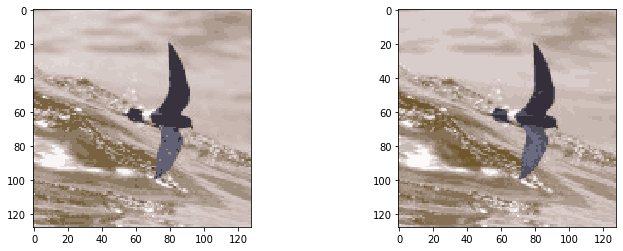

In [277]:
fig, axs = plt.subplots(1, 2, figsize=[12, 4])
axs[0].imshow(compressed_img)
axs[1].imshow(compressed_img_hier_cl)

Оба алгоритма дают примерно одинаковый результат. Мы использовали метод Уорда, 
этот метод применяется для задач с близко расположенными кластерами.